<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Store-data-in-S3-bucket" data-toc-modified-id="Store-data-in-S3-bucket-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Store data in S3 bucket</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Confusion Matrix</a></span></li><li><span><a href="#Estimate-or-load-models-and-make-predictions" data-toc-modified-id="Estimate-or-load-models-and-make-predictions-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Estimate or load models and make predictions</a></span></li><li><span><a href="#Voting-classifier" data-toc-modified-id="Voting-classifier-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Voting classifier</a></span></li><li><span><a href="#Adjust-the-decision-threshold" data-toc-modified-id="Adjust-the-decision-threshold-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Adjust the decision threshold</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-1.0.4.1"><span class="toc-item-num">1.0.4.1&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-1.0.4.2"><span class="toc-item-num">1.0.4.2&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Other" data-toc-modified-id="Other-1.0.4.3"><span class="toc-item-num">1.0.4.3&nbsp;&nbsp;</span>Other</a></span></li></ul></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>XGBoost</a></span><ul class="toc-item"><li><span><a href="#OLD" data-toc-modified-id="OLD-1.0.5.1"><span class="toc-item-num">1.0.5.1&nbsp;&nbsp;</span>OLD</a></span></li><li><span><a href="#OLD" data-toc-modified-id="OLD-1.0.5.2"><span class="toc-item-num">1.0.5.2&nbsp;&nbsp;</span>OLD</a></span></li></ul></li><li><span><a href="#HpSklearn" data-toc-modified-id="HpSklearn-1.0.6"><span class="toc-item-num">1.0.6&nbsp;&nbsp;</span>HpSklearn</a></span></li><li><span><a href="#Hyperopt" data-toc-modified-id="Hyperopt-1.0.7"><span class="toc-item-num">1.0.7&nbsp;&nbsp;</span>Hyperopt</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data
 
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    GridSearchCV, ShuffleSplit

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_score, recall_score, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 


# Adjust number of CPU cores to use
n_jobs=1

In [2]:
# Load preprocessed training and test set, incl. feature names 
X_train_small = joblib.load('data_processed/X_train_small.joblib')
X_test_small = joblib.load('data_processed/X_test_small.joblib')
y_train_small = joblib.load('data_processed/y_train_small.joblib')
y_test_small = joblib.load('data_processed/y_test_small.joblib')
feature_names_small = joblib.load('data_processed/feature_names_small')

In [3]:
# Load preprocessed training and test set, incl. feature names 
X_train = joblib.load('data_processed/X_train.joblib')
X_test = joblib.load('data_processed/X_test.joblib')
y_train = joblib.load('data_processed/y_train.joblib')
y_test = joblib.load('data_processed/y_test.joblib')
feature_names = joblib.load('data_processed/feature_names')

In [ ]:
# Temporarily decrease sample size
X_train_small, y_train_small= resample(
    X_train_small, y_train_small ,
    replace=False, n_samples=500, random_state=1)
    
X_test_small, y_test_small= resample(
    X_test_small, y_test_small, 
    replace=False, n_samples=100, random_state=1)

In [ ]:
# Dictionaries to store results for SMALL data set
average_precision_1 = {}
classification_reports_1 = {}
most_important_features_1 = {} 

##  Store data in S3 bucket

In [ ]:
# Save preprocessed training and test sets
filenames_whole = ['X_train', 'X_test', 'y_train', 'y_test']
filenames_small = [filename + '_small' for filename in filenames_whole]
filenames = filenames_whole + filenames_small
files = [X_train, X_test, y_train, y_test,
         X_train_small, X_test_small, y_train_small, y_test_small]

for file, filename in zip(files, filenames):
    joblib.dump(file,
                'data_processed/{}.joblib'.format(filename))
# Delete temporary list to conserve memory
del files

# Save feature names
joblib.dump(feature_names, 'data_processed/feature_names')
joblib.dump(feature_names_small, 'data_processed/feature_names_small')

In [6]:
import boto3
# Set up boto3 to interact with S3
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')

In [7]:
# https://realpython.com/python-boto3-aws-s3/#installation
import uuid
def create_bucket_name(bucket_prefix):
    """Try to create globally unique bucket name."""
    return(''.join([bucket_prefix, str(uuid.uuid4())]))

bucket_name = create_bucket_name('lending-club-')
print(bucket_name)

lending-club-23452399-7068-40a5-8b74-889ed5372d4a


In [8]:
lc_bucket = s3.create_bucket(Bucket=bucket_name)

In [20]:
lc_bucket

s3.Bucket(name='lending-club-23452399-7068-40a5-8b74-889ed5372d4a')

In [18]:
# Print all buckets
for b in s3.buckets.all():
    print(b)

s3.Bucket(name='lending-club-1a6fe642-4a35-4878-a3e1-0fee33683a9f')
s3.Bucket(name='lending-club-23452399-7068-40a5-8b74-889ed5372d4a')


In [21]:
s3.Bucket(bucket_name) \
    .upload_file(Filename='data_processed/X_train.joblib',
                 Key='X_train_small.joblib')

In [ ]:
# s3.meta.client.upload_file(Filename='data_processed/X_train.joblib',
#                            Bucket=bucket_name,
#                            Key='X_train_small.joblib'))

#### Confusion Matrix

In [ ]:
y_svm_lin_custom = custom_prediction(y_pred_distance_svm_lin_1, 0.4)
print(classification_report(y_test_small, y_svm_lin_custom))

In [ ]:
y_svm_lin_custom = custom_prediction(y_pred_distance_svm_lin_1, 0.4)
def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    

# Plot confusion matrix 
plot_confusion_matrix(y_test_small, y_svm_lin_custom)

#### Estimate or load models and make predictions

In [ ]:
rf = RandomForestClassifier(n_estimators=100, 
        oob_score=False, n_jobs=n_jobs, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_small, y_train_small)

In [ ]:
# Load models
lr_gs_1 = joblib.load('saved_models/lr_gs_1.joblib')
svm_lin_gs_1 = joblib.load('saved_models/svm_lin_gs_1.joblib')
svm_rbf_gs_1 = joblib.load('saved_models/svm_rbf_gs_1.joblib')
svm_poly_gs_1 = joblib.load('saved_models/svm_poly_gs_1.joblib')

In [ ]:
# # Split the test set into validation set and proper test set for stacking
# X_val, X_t, y_val, y_t = train_test_split(
#     X_test_small, y_test_small, train_size=0.5, test_size=0.5,
#     stratify=y_test_small, random_state=1)

In [ ]:
## Predicted probability or distance from separating hyperplane 

# For TRAINING data:
y_proba_rf_tr = rf.predict_proba(X_train_small)[:, 1]
y_proba_lr_tr = lr_gs_1.predict_proba(X_train_small)[:, 1]
y_dist_svm_lin_tr = svm_lin_gs_1.decision_function(X_train_small)
y_dist_svm_rbf_tr = svm_rbf_gs_1.decision_function(X_train_small)
y_dist_svm_poly_tr = svm_poly_gs_1.decision_function(X_train_small)

In [ ]:
# For TEST data:
y_proba_rf_1 = rf.predict_proba(X_test_small)[:, 1]
y_proba_lr_1 = lr_gs_1.predict_proba(X_test_small)[:, 1]
y_dist_svm_lin_1 = svm_lin_gs_1.decision_function(X_test_small)
y_dist_svm_rbf_1 = svm_rbf_gs_1.decision_function(X_test_small)
y_dist_svm_poly_1 = svm_poly_gs_1.decision_function(X_test_small)

#### Voting classifier

#### Adjust the decision threshold

In [ ]:
# Define function to make a prediction with custom threshold
def custom_prediction(proba_or_dist, threshold):
    """
    Makes predictions for binary classification from probabilities or distance
    to separating hyperplane, given a custom threshold.
    """

    return (proba_or_dist > threshold).astype(int)


# Define function to plot effect of threshold on precision and recall
def plot_threshold(proba_or_dist, y_true, thresholds=None):
    """
    Plot precision and recall as a function of decision threshold for an array of
    probabilities or distances to separating hyperplane.

    If no custom list of thresholds is supplied, it defaults to a grid of length 
    100, spanning between the minimum and maximum probability/distance. (In
    order to avoid thresholds that assign all observations to a single class, 
    the smallest and largest thresholds are offset by 0.01 from the minimum and 
    maximum probability/distance.)

    Parameters
    ----------
    proba_or_dist: array-like
        Probabilities or distance from separating hyperplane
    y_true: array-like
        True values of target variable.
    thresholds: list-like
        Custom thresholds. Optional.  
        
    Returns
    -------
        None
    """
    
    # Initialize dictionaries to store results
    classes = {}
    precisions = {}
    recalls = {}
            
    # If no custom thresholds were passed, make grid between minimum and maximum
    # values for probability or distance.
    if thresholds is None:
        thresholds = np.linspace(proba_or_dist.min() + 0.01,
                                 proba_or_dist.max() - 0.01, 100)

    # Iterate over thresholds
    for threshold in thresholds:
        # Classify as 1 if probability/distance is greater than threshold, else 0
        classes[threshold] = custom_prediction(proba_or_dist, threshold)

        # Compute precision and recall
        precisions[threshold] = precision_score(y_true, classes[threshold])
        recalls[threshold] = recall_score(y_true, classes[threshold])

    # Combine precision and recall into a data frame, indexed by threshold
    pr_rec = pd.DataFrame({'precision': precisions, 'recall': recalls})

    # Plot results
    pr_rec.plot()
    plt.title('Effect of threshold on Precision and Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision\nRecall')
    plt.show()

##### Linear regression

In [ ]:
# Plot effect of probability threshold for linear regression
plot_threshold(proba_or_dist=y_proba_lr_1, y_true=y_test_small)

In [ ]:
y_lr_custom = custom_prediction(y_proba_lr_1, 0.4)
print(classification_report(y_test_small, y_lr_custom))

In [ ]:
y_lr_custom = custom_prediction(y_proba_lr_1, 0.4)
def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    

# Plot confusion matrix 
plot_confusion_matrix(y_test_small, y_lr_custom)

##### SVM

In [ ]:
# Plot effect of probability threshold for linear regression
plot_threshold(proba_or_dist=y_dist_svm_lin_1, y_true=y_test_small)

In [ ]:
y_svm_lin_custom = custom_prediction(y_dist_svm_lin_1, -0.5)
print(classification_report(y_test_small, y_svm_lin_custom))

In [ ]:
y_svm_lin_custom = custom_prediction(y_dist_svm_lin_1, -0.4)
def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    

# Plot confusion matrix 
plot_confusion_matrix(y_test_small, y_svm_lin_custom)

##### Other

In [ ]:
#     def plot_roc(y_test, y_pred, model_name=None):
#         false_positive_rate, true_positive_rate, thresholds = \
#             roc_curve(y_test, y_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         plt.plot(false_positive_rate, true_positive_rate, 'b',
#                  label='AUC = {0:.3f}'.format(roc_auc))
#         plt.legend(loc='lower right')
#         plt.plot([0, 1],[0, 1], 'r--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         title='ROC Curve'
#         # Add custom title, if specified
#         if model_name is not None:
#             title = ', '.join([title, model_name])
#         plt.title(title)
#         plt.show();

#     # Plot ROC curve for random forests
#     y_proba_rf = rf.predict_proba(X_test_p)[:, 1]
#     plot_roc(y_test, y_proba_rf, 'Random Forests')


#     def plot_precision_recall(y_test, y_pred):
#         """Plots precision-recall curve."""

#         average_precision = average_precision_score(y_test, y_pred)
#         precision, recall, _ = precision_recall_curve(y_test, y_pred)
#         # pdb.set_trace()
#         step_kwargs = ({'step': 'post'}
#                        if 'step' in signature(plt.fill_between).parameters
#                        else {})
#         plt.step(recall, precision, color='b', alpha=0.2,
#                  where='post')
#         plt.figtext(0.2, 0.2, 'Average Precision={0:0.3f}' \
#                                         .format(average_precision))
#         plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#         plt.xlabel('Recall')
#         plt.ylabel('Precision')
#         plt.ylim([0.0, 1.05])
#         plt.xlim([0.0, 1.0])
#         plt.title('Precision-Recall curve')
#         plt.show();

#     # Plot precision recall curve for random forests classifier
#     plot_precision_recall(y_test, y_proba_rf)

#     # Get a list of feature names
#     cat_names = preprocessor.named_transformers_['cat'] \
#                     .named_steps['onehot'].get_feature_names()
#     feature_names = list(numeric_features) + list(cat_names)
#     # Compute feature importance and sort
#     feature_importances = pd.Series(
#                                 rf.feature_importances_,
#                                 index=feature_names) \
#                             .sort_values(ascending=False)
#     print(feature_importances)

#### XGBoost

Since we have a lot of parameters to tune, we need a smart way of searching over the different parameters that avoids the combinatorial explosion that would result from a simultaneous grid search over all parameters.  

suggestions from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/.

We will start with a high learning rate to speed up computation, and then determine the ideal number of estimators for this learning rate.  Later, we will tune tree-specific parameters.

In [7]:
import csv
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [ ]:
# Remove "<" from feature names, since this causes problems for xgboost
feature_names_xgb = [x.replace('<', '_less_than_') for x in feature_names_small]

# Convert data to DMatrix for improved performance
data_xgb_train = xgb.DMatrix(data=X_train_small, label=y_train_small,
                             feature_names=feature_names_xgb)
data_xgb_test = xgb.DMatrix(data=X_test_small, label=y_test_small,
                            feature_names=feature_names_xgb)

In [ ]:
# Inspect prior distribution for reg_alpha
from hyperopt import pyll
reg_alpha_distr = hp.loguniform('n_estimators', -6, 4)
samples = [pyll.stochastic.sample(reg_alpha_distr) for i in range(100)]

# Plot
sns.distplot(pd.Series(samples))

# Descriptive statistics
pd.Series(samples).describe()

In [8]:
N_JOBS=1
MAX_EVALS = 2

# CSV file to track progress
progress_file_path = 'hp_progress/progress_xgb.csv'
with open(progress_file_path, 'w') as file:
    writer = csv.writer(file)
    # Write header to the file
    writer.writerow(['loss', 'params', 'n_trees'])

# Function to convert sampled parameters to integer or make positive, etc., 
# where necessary
def adjust_params_xgb(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Convert sampled parameters to integer, where  applicable
    params['max_depth'] = round(params['max_depth'])
    
    # Make sure parameters are positive, where applicable
    if params['min_child_weight'] <= 0:
        params['min_child_weight'] = 1 # Set to default
    # Gamma will be negative half the time, so let's take absolute value
    params['gamma'] = np.abs(params['gamma'])

    # Set min or max thresholds for parameters, where applicable
    if params['max_depth'] <= 2:
        params['max_depth'] = 6 # Set to default
    if params['subsample'] < 0 or params['subsample'] > 1:
        params['subsample'] = 0.75
    if params['colsample_bytree'] < 0 or params['colsample_bytree'] > 1:
        params['colsample_bytree'] = 0.75
    
    # Return modified parameters
    return params


# Objective function to minimize
def objective(params, progress_file_path=progress_file_path,
              n_jobs=N_JOBS):
    """Objective function to minimize"""
    
    # Adjust parameters
    params = adjust_params_xgb(params)
    
    # Train model
    xgb_ = xgb.train(params, dtrain=data_xgb_train, 
                num_boost_round=1000,
                evals=[(data_xgb_test, "test")], # Remember to use a separate validation set later!!!
                early_stopping_rounds=50) 
    
    # Compute loss as the negative mean of the average precision scores
    # (since hyperopt can only minimize a function)
    loss = - xgb_.best_score
    
    # Save results to csv file
    with open(progress_file_path, 'a') as file:
        writer = csv.writer(file)
        writer.writerow([loss, params, xgb_.best_ntree_limit])

    # Return results
    return {'loss': loss, 'params': params, 'n_trees': xgb_.best_ntree_limit, 'status': STATUS_OK}


space = {
    # Parameters that we are going to tune (Note that these may be modified
    # in objective function to convert to integer or to set min or max.)
    'eta':.3,  # Start with a higher learning rate for speed
    'objective':'binary:logistic',
    'eval_metric':'map',
    'scale_pos_weight': 5,  # Balance classes
    'max_depth': hp.normal('max_depth', 6, 2),
    'min_child_weight': hp.normal('min_child_weight', 4, 2), 
    'gamma': hp.normal('gamma', 0, 0.2),  # We will take absolute value
    'subsample': hp.normal('subsample', 0.75, 0.2), 
    'colsample_bytree':  hp.normal('colsample_bytree', 0.75, 0.2),
    'reg_alpha': hp.loguniform('reg_alpha', -6, 4),
    'verbose_eval': False
}


# Minimize objective
best = fmin(objective, space, algo=tpe.suggest,
            max_evals=MAX_EVALS)

# Get the values of the optimal parameters
best_params = space_eval(space, best)

[12:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 2 pruned nodes, max_depth=8
[0]	test-map:0.326634
Will train until test-map hasn't improved in 50 rounds.
[12:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 2 pruned nodes, max_depth=8
[1]	test-map:0.334192
[12:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 2 pruned nodes, max_depth=8
[2]	test-map:0.340374
[12:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 10 pruned nodes, max_depth=8
[3]	test-map:0.348719
[12:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 14 pruned nodes, max_depth=8
[4]	test-map:0.349043
[12:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[12:56:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 8 pruned nodes, max_depth=8
[47]	test-map:0.346603
[12:56:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 16 pruned nodes, max_depth=8
[48]	test-map:0.346214
[12:56:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 12 pruned nodes, max_depth=8
[49]	test-map:0.346161
[12:56:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 10 pruned nodes, max_depth=8
[50]	test-map:0.346106
[12:56:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 18 pruned nodes, max_depth=8
[51]	test-map:0.347144
[12:56:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra node

[30]	test-map:0.367898
[12:56:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[31]	test-map:0.367679
[12:56:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[32]	test-map:0.367213
[12:56:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[33]	test-map:0.36777
[12:56:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[34]	test-map:0.367435
[12:56:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[35]	test-map:0.368849
[12:56:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3

Best average precision on validation set: 0.37081


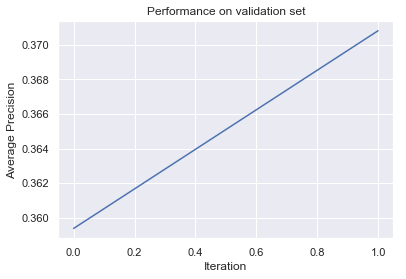

In [9]:
# Load full results from progress file
xgb_results = pd.read_csv('hp_progress/progress_xgb.csv')

# Get validation score
# Extract AP for each iteration
ap_xgb = - xgb_results.loss

print(f'Best average precision on validation set: {ap_xgb.max()}')

# Plot AP per iteration
ap_xgb.plot()
plt.title('Performance on validation set')
plt.ylabel('Average Precision')
plt.xlabel('Iteration');

Now that we have identified the best parameters, let's re-estimate the model with a lower learning rate to get another boost in accuracy.

In [13]:
# Decrease learning rate
best_params['eta'] = 0.005

# Adjust parameters (e.g., convert to integer)
best_params = adjust_params_xgb(best_params)

# Fit the model with the optimal hyperparamters and lower learning rate
xgb_best = xgb.train(best_params,
                    dtrain=data_xgb_train, 
                    num_boost_round=1000,
                    evals=[(data_xgb_test, "test")], # Remember to use a separate validation set later!!!
                    early_stopping_rounds=50) 
xgb_best.best_score    

[13:00:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	test-map:0.320254
Will train until test-map hasn't improved in 50 rounds.
[13:00:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	test-map:0.335677
[13:00:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	test-map:0.340617
[13:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	test-map:0.341409
[13:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	test-map:0.342218
[13:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74:

[13:00:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[47]	test-map:0.358498
[13:00:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[48]	test-map:0.358355
[13:00:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[49]	test-map:0.357848
[13:00:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[50]	test-map:0.357712
[13:00:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[51]	test-map:0.357787
[13:00:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 prune

[13:00:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[95]	test-map:0.359183
[13:00:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[96]	test-map:0.358977
[13:00:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[97]	test-map:0.359007
[13:00:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[98]	test-map:0.358971
[13:00:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[99]	test-map:0.358795
[13:00:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 prune

[141]	test-map:0.360771
[13:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[142]	test-map:0.360813
[13:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[143]	test-map:0.360714
[13:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[144]	test-map:0.360703
[13:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[145]	test-map:0.360742
[13:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[146]	test-map:0.360868
[13:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 r

[13:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[189]	test-map:0.362509
[13:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[190]	test-map:0.362651
[13:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[191]	test-map:0.36258
[13:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[192]	test-map:0.362682
[13:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[193]	test-map:0.362762
[13:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 p

[235]	test-map:0.366159
[13:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[236]	test-map:0.366271
[13:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[237]	test-map:0.366348
[13:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[238]	test-map:0.36639
[13:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[239]	test-map:0.366511
[13:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[240]	test-map:0.366678
[13:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 ro

[328]	test-map:0.37258
[13:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[329]	test-map:0.372567
[13:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[330]	test-map:0.372587
[13:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[331]	test-map:0.372604
[13:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[332]	test-map:0.372616
[13:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[333]	test-map:0.372662
[13:00:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 ro

[375]	test-map:0.374395
[13:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[376]	test-map:0.374474
[13:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[377]	test-map:0.374584
[13:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[378]	test-map:0.374645
[13:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[379]	test-map:0.374646
[13:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[380]	test-map:0.374642
[13:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 r

[13:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[423]	test-map:0.375885
[13:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[424]	test-map:0.375937
[13:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[425]	test-map:0.375932
[13:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[426]	test-map:0.376034
[13:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[427]	test-map:0.376065
[13:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 

[13:00:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[470]	test-map:0.377145
[13:00:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[471]	test-map:0.377142
[13:00:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[472]	test-map:0.377231
[13:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[473]	test-map:0.377189
[13:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[474]	test-map:0.377207
[13:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 

[516]	test-map:0.378336
[13:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[517]	test-map:0.378412
[13:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[518]	test-map:0.378432
[13:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[519]	test-map:0.378443
[13:00:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[520]	test-map:0.37848
[13:00:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[521]	test-map:0.37856
[13:00:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roo

[13:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[564]	test-map:0.379699
[13:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[565]	test-map:0.379727
[13:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[566]	test-map:0.379662
[13:01:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[567]	test-map:0.379674
[13:01:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[568]	test-map:0.379622
[13:01:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 

[13:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[611]	test-map:0.380162
[13:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[612]	test-map:0.380207
[13:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[613]	test-map:0.380284
[13:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[614]	test-map:0.380236
[13:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[615]	test-map:0.380263
[13:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 

[13:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=5
[658]	test-map:0.381167
[13:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[659]	test-map:0.381167
[13:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[660]	test-map:0.381199
[13:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[661]	test-map:0.381205
[13:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[662]	test-map:0.381213
[13:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 

[13:01:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[705]	test-map:0.381747
[13:01:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[706]	test-map:0.381624
[13:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[707]	test-map:0.381619
[13:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[708]	test-map:0.381735
[13:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=5
[709]	test-map:0.381818
[13:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 

[13:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[752]	test-map:0.382001
[13:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[753]	test-map:0.382042
[13:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[754]	test-map:0.382079
[13:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[755]	test-map:0.382116
[13:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[756]	test-map:0.382127
[13:01:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 

0.3827

In [16]:
# Add optimum number of trees to best parameters
best_params['num_boost_round'] = xgb_best.best_ntree_limit
# Remove early stopping, because now we don't need it anymore
best_params['early_stopping_rounds'] = None

In [20]:
# Save feature importances
fi_xgb = pd.Series(xgb_best.get_fscore()) \
            .sort_values(ascending=False)
feature_importances = {}
feature_importances['xgb'] = fi_xgb
fi_xgb

log_installment                                   1555
dti                                               1504
fico_range_low                                    1035
log1p_annual_inc                                   979
log1p_avg_cur_bal                                  874
acc_open_past_24mths                               819
log1p_bc_open_to_buy                               765
log1p_mths_since_recent_bc                         743
log1p_tot_hi_cred_lim                              705
log1p_revol_bal                                    685
log_mo_sin_old_rev_tl_op                           652
log1p_total_bc_limit                               580
mo_sin_old_il_acct                                 560
log1p_total_rev_hi_lim                             545
revol_util                                         519
log_funded_amnt                                    508
log1p_total_il_high_credit_limit                   503
term_5y                                            497
total_acc 

In [22]:
fi_xgb.loc[fi_xgb.index.str.contains('to_inc')]

Series([], dtype: int64)

In [27]:
pd.Series(feature_names_small).pd.Series(feature_names_small).str.contains('to_inc')]

SyntaxError: invalid syntax (<ipython-input-27-12d931e1edd4>, line 1)

In [33]:
list(filter(lambda x: 'to_inc' in x, feature_names_small))

[]

In [ ]:
# Pickle best model
with open('saved_models/xgb_best.pickle', 'wb') as pickled_file: 
    pickle.dump(xgb_best, pickled_file) 
with open('saved_models/xgb_best_params.pickle', 'wb') as pickled_file: 
    pickle.dump(best_params, pickled_file) 

In [4]:
## Load best model and data
with open('saved_models/xgb_best.pickle', 'rb') as pickled_file: 
    xgb_best = pickle.load(pickled_file) 
with open('saved_models/xgb_best_params.pickle', 'rb') as pickled_file: 
    xgb_best_params = pickle.load(pickled_file) 
    
# Load preprocessed training and test set, incl. feature names 
X_train_small = joblib.load('data_processed/X_train_small.joblib')
X_test_small = joblib.load('data_processed/X_test_small.joblib')
y_train_small = joblib.load('data_processed/y_train_small.joblib')
y_test_small = joblib.load('data_processed/y_test_small.joblib')
feature_names_small = joblib.load('data_processed/feature_names_small')

# Convert data to DMatrix for improved performance
feature_names_xgb = [x.replace('<', '_less_than_') for x in feature_names_small]
data_xgb_train = xgb.DMatrix(data=X_train_small, label=y_train_small,
                             feature_names=feature_names_xgb)
data_xgb_test = xgb.DMatrix(data=X_test_small, label=y_test_small,
                            feature_names=feature_names_xgb)

In [5]:
## Compute test score of final model
# Make predicition
y_xgb = xgb_best.predict(data_xgb_test)
y_xgb

# Save and print AP
ap_xgb = average_precision_score(y_test_small, y_xgb)
print(f'Average precision on test set: {ap_xgb}')
average_precision['xgb'] = ap_xgb

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118'] ['dti', 'fico_range_low', 'fico_range_high', 'open_acc', 'revol_util', 'total_acc', 'acc_open_past_24mths', 'bc_util', 'mo_sin_old_il_acct', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'term_5y', 'log_funded_amnt', 'log_installment', 'log1p_annual_inc', 'log1p_delinq_2yrs', 'log1p_inq_last_6mths', 'log1p_pub_rec', 'log1p_revol_bal', 'log1p_collections_12_mths_ex_med', 'log1p_acc_now_delinq', 'log1p_tot_coll_amt', 'log1p_tot_cur_bal', 'log1p_total_rev_hi_lim', 'log1p_avg_cur_bal', 'log1p_bc_open_to_buy', 'log1p_chargeoff_within_12_mths', 'log1p_delinq_amnt', 'log_mo_sin_old_rev_tl_op', 'log1p_mo_sin_rcnt_rev_tl_op', 'log1p_mo_sin_rcnt_tl', 'log1p_mort_acc', 'log1p_mths_since_recent_bc', 'log1p_mths_since_recent_inq', 'log1p_num_accts_ever_120_pd', 'log1p_num_actv_bc_tl', 'log1p_num_bc_sats', 'log1p_num_bc_tl', 'log1p_num_il_tl', 'log1p_num_op_rev_tl', 'log1p_num_rev_accts', 'log1p_num_tl_120dpd_2m', 'log1p_num_tl_30dpd', 'log1p_num_tl_90g_dpd_24m', 'log1p_pub_rec_bankruptcies', 'log1p_tax_liens', 'log1p_tot_hi_cred_lim', 'log1p_total_bal_ex_mort', 'log1p_total_bc_limit', 'log1p_total_il_high_credit_limit', 'log1p_inv_sqrt_1p_mths_since_last_record', 'log1p_inv_sqrt_1p_mths_since_recent_bc_dlq', 'log1p_inv_sqrt_1p_mths_since_last_major_derog', 'log1p_inv_sqrt_1p_mths_since_recent_revol_delinq', 'log1p_inv_sqrt_1p_mths_since_last_delinq', 'log_earliest_cr_line_days', 'x0_ 36 months', 'x0_ 60 months', 'x1_1 year', 'x1_10+ years', 'x1_2 years', 'x1_3 years', 'x1_4 years', 'x1_5 years', 'x1_6 years', 'x1_7 years', 'x1_8 years', 'x1_9 years', 'x1__less_than_ 1 year', 'x2_ANY', 'x2_MORTGAGE', 'x2_NONE', 'x2_OTHER', 'x2_OWN', 'x2_RENT', 'x3_Not Verified', 'x3_Source Verified', 'x3_Verified', 'x4_car', 'x4_credit_card', 'x4_debt_consolidation', 'x4_educational', 'x4_home_improvement', 'x4_house', 'x4_major_purchase', 'x4_medical', 'x4_moving', 'x4_other', 'x4_renewable_energy', 'x4_small_business', 'x4_vacation', 'x4_wedding', 'x5_Individual', 'x5_Joint App', 'x6_Cash', 'x6_DirectPay', 'max_pct_tl_nvr_dlq', 'min_delinq_2yrs', 'min_pub_rec', 'min_revol_bal', 'min_collections_12_mths_ex_med', 'min_tot_coll_amt', 'min_bc_open_to_buy', 'min_chargeoff_within_12_mths', 'min_delinq_amnt', 'min_num_accts_ever_120_pd', 'min_num_tl_90g_dpd_24m', 'min_pub_rec_bankruptcies', 'min_tax_liens', 'min_total_il_high_credit_limit', 'min_inv_sqrt_1p_mths_since_last_record', 'min_inv_sqrt_1p_mths_since_recent_bc_dlq', 'min_inv_sqrt_1p_mths_since_last_major_derog', 'min_inv_sqrt_1p_mths_since_recent_revol_delinq', 'min_inv_sqrt_1p_mths_since_last_delinq']
expected f39, f118, f16, f6, f40, f65, f87, f1, f111, f29, f90, f79, f56, f55, f5, f13, f34, f30, f45, f8, f32, f97, f84, f103, f50, f49, f98, f14, f63, f95, f114, f113, f105, f88, f41, f112, f57, f7, f27, f20, f104, f72, f60, f78, f85, f35, f2, f18, f38, f66, f0, f94, f108, f71, f77, f46, f53, f116, f62, f109, f86, f52, f110, f10, f64, f59, f61, f17, f24, f75, f89, f15, f101, f47, f106, f117, f9, f28, f76, f115, f70, f69, f68, f58, f11, f19, f99, f92, f36, f12, f43, f22, f25, f73, f54, f31, f107, f91, f81, f82, f74, f4, f96, f83, f44, f42, f3, f26, f100, f33, f67, f102, f48, f37, f21, f51, f23, f80, f93 in input data
training data did not have the following fields: x2_NONE, min_inv_sqrt_1p_mths_since_last_major_derog, log1p_acc_now_delinq, x6_Cash, min_collections_12_mths_ex_med, x1__less_than_ 1 year, max_pct_tl_nvr_dlq, min_inv_sqrt_1p_mths_since_recent_revol_delinq, log1p_pub_rec, log1p_revol_bal, log1p_inv_sqrt_1p_mths_since_last_delinq, fico_range_high, min_num_tl_90g_dpd_24m, num_actv_rev_tl, num_rev_tl_bal_gt_0, log1p_num_tl_120dpd_2m, log1p_inv_sqrt_1p_mths_since_last_major_derog, min_delinq_2yrs, min_inv_sqrt_1p_mths_since_recent_bc_dlq, log1p_delinq_2yrs, log1p_num_tl_90g_dpd_24m, log1p_tot_hi_cred_lim, log1p_mort_acc, min_pub_rec_bankruptcies, log1p_num_bc_tl, x2_OWN, x1_9 years, log1p_tot_cur_bal, log1p_mths_since_recent_bc, x4_renewable_energy, x1_6 years, acc_open_past_24mths, log1p_num_il_tl, x1_2 years, x1_1 year, log1p_num_accts_ever_120_pd, log1p_mths_since_recent_inq, x2_ANY, x4_vacation, x3_Verified, log1p_pub_rec_bankruptcies, log1p_tax_liens, log1p_num_bc_sats, mo_sin_old_il_acct, num_sats, log1p_inv_sqrt_1p_mths_since_recent_bc_dlq, x4_debt_consolidation, log1p_inv_sqrt_1p_mths_since_recent_revol_delinq, x1_3 years, num_tl_op_past_12m, log1p_avg_cur_bal, log1p_annual_inc, log1p_num_op_rev_tl, x4_small_business, log1p_mo_sin_rcnt_rev_tl_op, log1p_num_rev_accts, x2_RENT, fico_range_low, log1p_total_il_high_credit_limit, log1p_total_rev_hi_lim, log1p_total_bc_limit, min_num_accts_ever_120_pd, x4_home_improvement, open_acc, x6_DirectPay, log1p_tot_coll_amt, x1_8 years, min_chargeoff_within_12_mths, min_inv_sqrt_1p_mths_since_last_delinq, log1p_collections_12_mths_ex_med, log1p_delinq_amnt, x4_credit_card, log1p_num_actv_bc_tl, x3_Source Verified, log1p_inq_last_6mths, x1_4 years, total_acc, revol_util, min_total_il_high_credit_limit, x4_moving, log_earliest_cr_line_days, x2_OTHER, min_pub_rec, log_installment, log_mo_sin_old_rev_tl_op, x4_other, percent_bc_gt_75, min_inv_sqrt_1p_mths_since_last_record, x4_car, dti, pct_tl_nvr_dlq, x3_Not Verified, min_bc_open_to_buy, log1p_num_tl_30dpd, min_revol_bal, x0_ 60 months, x1_5 years, log1p_chargeoff_within_12_mths, min_tax_liens, x0_ 36 months, min_tot_coll_amt, x1_7 years, x4_major_purchase, x2_MORTGAGE, log1p_total_bal_ex_mort, x4_wedding, term_5y, log1p_bc_open_to_buy, log_funded_amnt, x4_house, x5_Joint App, x5_Individual, bc_util, log1p_inv_sqrt_1p_mths_since_last_record, log1p_mo_sin_rcnt_tl, min_delinq_amnt, x4_educational, x1_10+ years, x4_medical

##### OLD

In [ ]:
# Save and print AP
ap_xgb = average_precision_score(y_test_small, y_xgb)
print(f'Average precision on test set: {ap_xgb}')
average_precision['xgb'] = ap_xgb

In [ ]:
# Parameters to search over
param_grid = {'max_depth'= [3, 5, 7, 10],  # Control complexity
              'min_child_weight'= , # The higher, the more regularization
              'gamma'= 0, # Higher value leads to fewer splits for a given node (i.e. more regularization) if
              'subsample'= [0.5, 0.75, 1],  # Fraction of observations per tree 
              'colsample_bytree': [0.5, 0.75, 1]} # Fraction of features per tree
# Grid search
xgb_gs_1 = GridSearchCV(xgb_1, param_grid=param_grid, 
                        num_boo
                        scoring='average_precision',
                        return_train_score=True,
                        n_jobs=N_JOBS, cv=3, verbose=5)
xgb_gs_1.fit(X_train_small, y_train_small) 

# Save model
joblib.dump(xgb_gs_1, 'saved_models/xgb_gs_1.joblib')

# Predictions
y_proba_xgb = xgb_.predict_proba(X_test_small)[:, 1]
average_precision_score(y_test_small, y_proba_xgb)

In [ ]:
xgb_1 = XGBClassifier(objective='binary:logistic', learning_rate=0.1,
               n_estimators=1000,
               max_depth=5,min_child_weight=1, gamma=0,
               subsample=0.8, colsample_bytree=0.8,
               seed=0, nthread=N_JOBS)
xgb_1.fit(X_train_small, y_train_small,
          early_stopping_rounds=50,
          eval_set=[(X_test_small, y_test_small)],
          eval_metric='map'
         )

In [ ]:
# Save model
# joblib.dump(xgb_gs_1, 'saved_models/xgb_gs_1.joblib')

# Predictions
y_proba_xgb = xgb_1.predict_proba(X_test_small)[:, 1]
average_precision_score(y_test_small, y_proba_xgb)

In [ ]:
from xgboost import XGBClassifier
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb1.fit(xgb1, train, predictors)

In [ ]:
params = {'objective':'binary:logistic', 'eval_metric':'map',
         'scale_pos_weight':5,  # Balance class weight
         'seed':0}
xgb_cv = xgb.cv(dtrain=data_xgb_train, params=params, nfold=3,
                num_boost_round=50, as_pandas=True)

In [ ]:
y_xgb_cv = xgb_cv.predict(X_test_small)
average_precision_score(y_test_small, y_xgb_cv)

##### OLD

In [ ]:
import csv
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score, StratifiedKFold

# params = {'objective':'binary:logistic', 'eval_metric':'map',
#          'scale_pos_weight':5,  # Balance class weight
#          'seed':0, 'learning_rate':0.1, 'n_estimators':1000,
#          'max_depth':5, 'min_child_weight':1, 'gamma':0,
#          'subsample':0.8, 'colsample_bytree':0.8,
#          'nthread':4}
params = {
    # Parameters that we are going to tune.
    'eta':.3,  # Start with a higher learning rate for speed
    'objective':'binary:logistic',
    'eval_metric':'map',
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
}

N_JOBS = 1
space = {
    'objective':'binary:logistic', 
    'eval_metric':'map',
    'scale_pos_weight':5,  # Balance class weight
    'seed':0, 
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    # A problem with max_depth casted to float instead of int with
    # the hp.quniform method.
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'nthread': N_JOBS,
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
    'seed': random_state
    }
xgb_cv = xgb.train(params=params, dtrain=data_xgb_train, 
                num_boost_round=1000,
                evals=[(data_xgb_test, "test")], # Remember to use a separate validation set later!!!
                early_stopping_rounds=50) 
#                 stratified=True, num_boost_round=1000, 
#                 early_stopping_rounds=50, verbose_eval=False,
#                 as_pandas=True, seed=0)



In [ ]:
xgb_cv.best_ntree_limit

In [ ]:
xgb_cv.best_score

In [ ]:
xgb_cv.best_iteration

In [ ]:
# Find best hyperparameters
find_best_hp(
      xgb_cv, space, file_name='xgb_hp_1',
      X_train=X_train_small, y_train=y_train_small,
      max_evals=8*11, n_jobs=3, n_folds=3)

In [ ]:
progress_xgb = pd.read_csv('progress_xgb.csv')

In [ ]:
# Best average precision score on validation set
-progress_xgb.loss.min()

In [ ]:
ap = - progress_xgb.loss
ap.plot()
plt.title('Performance on Validation Set')
plt.ylabel('Average Precision')
plt.xlabel('Iteration');

In [ ]:
data_xgb_train = xgb.DMatrix(data=X_train_small, label=y_train_small)
# X_train_small_dmat = xgb.DMatrix(X_train_small)
# X_test_small_dmat = xgb.DMatrix(X_test_small)
# y_train_small_dmat = xgb.DMatrix(y_train_small[:, np.newaxis])
# y_test_small_dmat = xgb.DMatrix(y_test_small)

In [ ]:
# # specify parameters via map
# param = {'objective':'binary:logistic', 'eval_metric':'map',
#          'scale_pos_weight':5  # Balance class weight
#          'seed':0}
# num_round = 2

# train(param, X_train_small, num_round)
# y_pred = xgb_.predict(X_test_small)

In [ ]:
xgb_ = xgb.XGBClassifier(objective='binary:logistic', eval_metric='map',
                         scale_pos_weight=5,  # Balance class weight
                         seed=0, nthread=n_jobs)
# xgb_.fit(X_train_small, y_train_small)

# Parameters to search over
param_grid = {'max_depth'= [3, 5, 7, 10],  # Control complexity
              'min_child_weight'= , # The higher, the more regularization
              'gamma'= , # Higher value leads to fewer splits for a given node (i.e. more regularization) if
              'subsample'= [0.5, 0.75, 1],  # Fraction of observations per tree 
              'colsample_bytree': [0.5, 0.75, 1]} # Fraction of features per tree
# Grid search
xgb_gs_1 = GridSearchCV(xgb_1, param_grid=param_grid, 
                       scoring='average_precision',
                       return_train_score=True,
                       n_jobs=n_jobs, cv=3, verbose=5)
xgb_gs_1.fit(X_train_small, y_train_small) 

# Save model
joblib.dump(xgb_gs_1, 'saved_models/xgb_gs_1.joblib')

# Predictions
y_proba_xgb = xgb_.predict_proba(X_test_small)[:, 1]
average_precision_score(y_test_small, y_proba_xgb)

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [ ]:
params = {'objective':'binary:logistic', 'eval_metric':'map',
         'scale_pos_weight':5,  # Balance class weight
         'seed':0}
xgb_cv = xgb.cv(dtrain=data_xgb_train, params=params, nfold=3,
                num_boost_round=50, as_pandas=True)

In [ ]:
y_xgb_cv = xgb_cv.predict(X_test_small)
average_precision_score(y_test_small, y_xgb_cv)

In [ ]:
xgb_cv

#### HpSklearn

In [ ]:
from hpsklearn import HyperoptEstimator, svc
import hyperopt 

# svc_class_weight = 'balanced'
svc_C = 10
svm_rbf_1 = svc(name='svm_rbf_1', kernels=['rbf'], C=svc_C)
#                 class_weight=svc_class_weight) #'balanced',
#                 probability=False, cache_size=5000,
#                 random_state=1)
svm_rbf_hp_1 = HyperoptEstimator(classifier=svm_rbf_1,
                                 algo=hyperopt.tpe.suggest,
                                 max_evals=5)

svm_rbf_hp_1.fit(X_train_small, y_train_small)

####  Hyperopt 

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define hyperparameter search space
space = {
    'kernel': 'rbf',
    'cache_size': 10000,
    'class_weight': 'balanced',
    'random_state': 1
    'C': hp.uniform('C', 1E-10, 1E10),
    'gamma': hp.uniform('gamma', 1E-5, 1E8),
}

# Function to minimize
N_FOLDS=3
N_JOBS=-2
def objective(params, n_folds=N_FOLDS, n_jobs=N_JOBS):
    """Objective function to minimize"""
    
    # Instantiate estimator
    clf = SVC(**params)
    
    # Cross-validation object
    cv = StratifiedKFold(n_folds, random_state=1)
    
    # Compute average precision through CV
    score = cross_val_score(clf, X_train_small, y_train_small, cv=cv,
                            scoring='average_precision', n_jobs=n_jobs)
    
    # Return results
    return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

# Trials object to track progress
trials = Trials()

# Minimize objective
MAX_EVALS=50 
best = fmin(objective, space, algo=tpe.suggest,
            max_evals=MAX_EVALS, trials=trials)

print ('Best parameters: {}'.format(best))

In [ ]:
# Get the values of the optimal parameters
best_params = space_eval(space, best)

# Fit the model with the optimal hyperparamters
SVC.set_params(**best_params)
SVC.fit(X_train_small, y_train_small);

# Score with the test data
y_score = SVC.predict_proba(X_test_small)
ap_score = average_precision_score(y_test_small, y_score[:,1])